# House Price Prediction: Optimized Stacking Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data and Remove Outliers

Original Train Shape: (1460, 81)


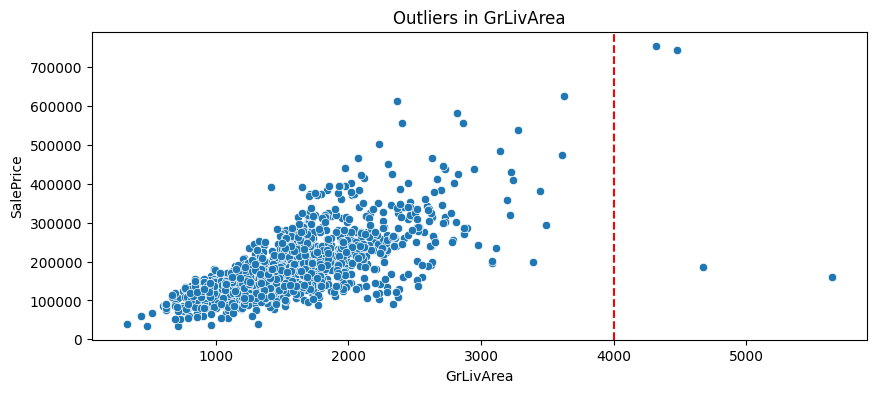

Train Shape after outlier removal: (1458, 81)


In [3]:
# Load datasets (Adjust paths if necessary)
train_df = pd.read_csv(r"D:\Projects\21Days-21Projects\Day 3\train.csv")
test_df = pd.read_csv(r"D:\Projects\21Days-21Projects\Day 3\test.csv")

print(f"Original Train Shape: {train_df.shape}")

# Visualizing Outliers
plt.figure(figsize=(10, 4))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.title("Outliers in GrLivArea")
plt.axvline(4000, color='r', linestyle='--')
plt.show()

# Removing Outliers (GrLivArea > 4000 and SalePrice < 300000)
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)
train_df.reset_index(drop=True, inplace=True)

print(f"Train Shape after outlier removal: {train_df.shape}")

## 2. Target Transformation

In [4]:
# Log-transform the target variable to normalize distribution
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

## 3. Data Integration & Cleaning

In [5]:
# Save IDs for submission
train_ID = train_df['Id']
test_ID = test_df['Id']

# Drop ID columns
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

# Concatenate for consistent preprocessing
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df.SalePrice.values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print(f"Combined Data Shape: {all_data.shape}")

Combined Data Shape: (2917, 79)


In [6]:
# --- MISSING VALUE IMPUTATION ---

# Fix Logic Error: GarageYrBlt should not be 0. If missing, assume same as house build year.
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(all_data['YearBuilt'])

# LotFrontage: Fill with median of neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Categorical features where NA means "None" (e.g., No Pool, No Fence)
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'MasVnrType']
for col in cols_fill_none:
    all_data[col] = all_data[col].fillna('None')

# Numerical features where NA means 0
cols_fill_0 = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in cols_fill_0:
    all_data[col] = all_data[col].fillna(0)

# Fill remaining categorical with Mode
cols_fill_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional']
for col in cols_fill_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

## 4. Advanced Feature Engineering & Skewness Correction

In [7]:
# Create engineered features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

# --- SKEWNESS CORRECTION ---
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Calculate skewness
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_df = pd.DataFrame({'Skew' :skewed_feats})

# Filter high skewness (> 0.75)
high_skew_feats = skewness_df[abs(skewness_df['Skew']) > 0.75].index
print(f"Transforming {len(high_skew_feats)} skewed features using Log1p...")

# Apply Log1p transformation
for feat in high_skew_feats:
    all_data[feat] = np.log1p(all_data[feat])

Transforming 21 skewed features using Log1p...


## 5. Smart Encoding (Ordinal + One-Hot)

In [8]:
# 1. Ordinal Encoding for Ranked Features
ordinal_cols_mapping = {
    "Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0,
    "GlQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1,
    "GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "NA": 0
}

cols_to_map = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
               'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtFinType1', 'BsmtFinType2']

for col in cols_to_map:
    all_data[col] = all_data[col].map(ordinal_cols_mapping).fillna(0)

# 2. One-Hot Encoding for Nominal Features (e.g., Neighborhood)
all_data = pd.get_dummies(all_data)
print(f"Shape after encoding: {all_data.shape}")

Shape after encoding: (2917, 253)


## 6. Scaling and Splitting

In [9]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Split for validation
X_train, X_val, y_train_split, y_val_split = train_test_split(train, y_train, test_size=0.2, random_state=42)

# Robust Scaling (Handling outliers better than Standard Scaler in some cases, but Standard is fine too)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)

## 7. Stacking Ensemble Model

In [10]:
# Define Base Models
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.0005)
xgb_model = xgb.XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=4, 
                             min_child_weight=1, gamma=0, subsample=0.7, 
                             colsample_bytree=0.7, objective='reg:squarederror', random_state=42)
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.01, 
                               n_estimators=3000, max_bin=200, bagging_fraction=0.75, 
                               bagging_freq=5, bagging_seed=7, feature_fraction=0.2, 
                               feature_fraction_seed=7, verbose=-1)

# Define Stacking Ensemble
# We use Lasso as the meta-learner to select the best combination of base models
estimators = [
    ('ridge', ridge),
    ('lasso', lasso),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=Ridge())

print("Training Stacking Ensemble...")
stack_reg.fit(X_train_scaled, y_train_split)
print("Training Complete.")

Training Stacking Ensemble...
Training Complete.


In [11]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.5f}")
    print(f"MAE:  {mae:.5f}")
    print(f"R2:   {r2:.5f}\n")

# Validate
y_pred_val = stack_reg.predict(X_val_scaled)
evaluate_model(y_val_split, y_pred_val, "Stacked Ensemble")

--- Stacked Ensemble Performance ---
RMSE: 0.11202
MAE:  0.07712
R2:   0.92556



## 8. Final Prediction and Submission

In [12]:
# Predict on Test Data
final_pred_log = stack_reg.predict(test_scaled)

# Inverse Log Transform to get actual prices
final_pred = np.expm1(final_pred_log)

# Create Submission File
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': final_pred})
submission.to_csv('optimized_submission.csv', index=False)

print("Submission file 'optimized_submission.csv' created successfully.")
submission.head()

Submission file 'optimized_submission.csv' created successfully.


,Id,SalePrice
0,1461,122887.587622
1,1462,161442.052832
2,1463,185498.966163
3,1464,193845.565169
4,1465,190173.507468
